In [1]:
import models
import numpy as np
import os
import sys
import config_vmc as cv_module
from numba import jit
from scipy.linalg import schur
from copy import deepcopy

def import_config(filename: str):
    import importlib

    module_name, extension = os.path.splitext(os.path.basename(filename))
    module_dir = os.path.dirname(filename)
    if extension != ".py":
        raise ValueError(
            "Could not import the module from {!r}: not a Python source file.".format(
                filename
            )
        )
    if not os.path.exists(filename):
        raise ValueError(
            "Could not import the module from {!r}: no such file or directory".format(
                filename
            )
        )
    sys.path.insert(0, module_dir)
    module = importlib.import_module(module_name)
    sys.path.pop(0)
    return module

@jit(nopython=True)
def get_fft(N, n_bands):
    W = np.zeros((N ** 2, N ** 2), dtype=np.complex128)
    for kx in range(N):
        for ky in range(N):
            for x in range(N):
                for y in range(N):
                    W[x * N + y, kx * N + ky] = np.exp(2.0j * np.pi / N * kx * x + 2.0j * np.pi / N * ky * y)
    return np.kron(W, np.eye(n_bands))
L = 6
config_vmc_file = import_config('./config_vmc.py')
config_vmc_import = config_vmc_file.MC_parameters(L, 0)
config = cv_module.MC_parameters(L, 0)
config.__dict__ = config_vmc_import.__dict__.copy()

@jit(nopython=True)
def fermi(energy, beta):
    return 1 / (1. + np.exp(energy * beta))

[1, 1]
[1, 1]
energy_free_theory =  -0.517342083544613
[-1.07733560e+00 -1.07733560e+00 -1.07733560e+00 -1.07733560e+00
 -1.07733560e+00 -1.07733560e+00 -1.04375261e+00 -1.04375261e+00
 -1.04375261e+00 -1.04375261e+00 -1.04375261e+00 -1.04375261e+00
 -9.93000000e-01 -9.93000000e-01 -7.07734756e-01 -7.07734756e-01
 -7.07734756e-01 -7.07734756e-01 -7.07734756e-01 -7.07734756e-01
 -6.62000000e-01 -6.62000000e-01 -6.62000000e-01 -6.62000000e-01
 -6.62000000e-01 -6.62000000e-01 -6.62000000e-01 -6.62000000e-01
 -6.62000000e-01 -6.62000000e-01 -6.62000000e-01 -6.62000000e-01
 -4.99008928e-01 -4.99008928e-01 -4.99008928e-01 -4.99008928e-01
 -4.99008928e-01 -4.99008928e-01 -4.99008928e-01 -4.99008928e-01
 -4.99008928e-01 -4.99008928e-01 -4.99008928e-01 -4.99008928e-01
 -3.31000000e-01 -3.31000000e-01 -3.31000000e-01 -3.31000000e-01
 -3.31000000e-01 -3.31000000e-01 -1.62991072e-01 -1.62991072e-01
 -1.62991072e-01 -1.62991072e-01 -1.62991072e-01 -1.62991072e-01
 -1.62991072e-01 -1.62991072e-01 -1

In [56]:
Ls = config.Ls
K0 = config.K_0
n_bands = 4
beta = 0.1
fft = get_fft(Ls, n_bands)
print(np.unique(K0))

K0 = K0 - np.diag(np.diag(K0) * 0. + 0.01)
### doing the FFT of K0 ###
K0_fft = fft.conj().T.dot(K0).dot(fft)

K0_check = K0_fft.copy()
for i in range(K0_check.shape[0] // n_bands):
    K0_check[i * n_bands:i * n_bands + n_bands,i * n_bands:i * n_bands + n_bands] = 0.0
assert np.isclose(np.sum(np.abs(K0_check)), 0.0)


A = np.zeros((L, L, n_bands, n_bands), dtype=np.complex128)
energies = np.zeros((L, L, n_bands), dtype=np.complex128)
for i in range(K0_check.shape[0] // n_bands):
    kx, ky = i % L, i // L
    A[kx, ky, ...] = np.linalg.eigh(K0_fft[i * n_bands:i * n_bands + n_bands,i * n_bands:i * n_bands + n_bands])[1]
    energies[kx, ky, ...] = np.linalg.eigh(K0_fft[i * n_bands:i * n_bands + n_bands,i * n_bands:i * n_bands + n_bands])[0]

    
@jit(nopython=True)
def get_susc_zero(Ls, n_bands, A, A_plus_q, energies, energies_plus_q, omega, temp):
    chi = np.zeros((n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)
    for kx in range(Ls):
        for ky in range(Ls):
            for alpha in range(n_bands):
                for beta in range(n_bands):
                    for p in range(n_bands):
                        for q in range(n_bands):
                            for s in range(n_bands):
                                for t in range(n_bands):
                                    chi[p, q, s, t] -= A[kx, ky, s, alpha] * \
                                               np.conj(A[kx, ky, p, alpha]) * \
                                                       A_plus_q[kx, ky, q, beta] * \
                                               np.conj(A_plus_q[kx, ky, t, beta]) / \
                                                (omega + energies_plus_q[kx, ky, beta] - energies[kx, ky, alpha] + 1e-10j) * \
                                                (fermi(energies_plus_q[kx, ky, beta], temp) - fermi(energies[kx, ky, alpha], temp))
                 
    return chi / n_bands / Ls ** 2 ## FIXME: factor?

susc_0 = np.zeros((L, L, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)
for qx in range(Ls):
    for qy in range(Ls):
        A_plus_q = np.roll(A, shift = qx, axis=0)
        A_plus_q = np.roll(A_plus_q, shift = qy, axis=1)
    
        energies_plus_q = np.roll(energies, shift = qx, axis=0)
        energies_plus_q = np.roll(energies_plus_q, shift = qy, axis=1)
        susc_0[qx, qy, ...] = get_susc_zero(Ls, n_bands, A, A_plus_q, energies, energies_plus_q, 0., beta)
        
        for a in range(4):
            for b in range(4):
                for c in range(4):
                    for d in range(4):
                        if (a + c) % 2 != (b + d) %2:
                            assert np.isclose(susc_0[qx, qy, a, b, c, d], 0.0)
        ## conserve valley quantum number
                        
susc_uniform = np.sum(susc_0[:, :, np.arange(n_bands), np.arange(n_bands), :, :], axis=2)
susc_uniform = np.sum(susc_uniform[:, :, np.arange(n_bands), np.arange(n_bands)], axis=-1).real

[0.   -0.097j 0.   +0.j    0.   +0.097j 0.331+0.j   ]


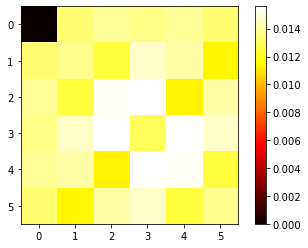

In [3]:
import matplotlib.pyplot as plt
plt.imshow(susc_uniform, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [116]:
Alat = np.array([[1, 0], [1. / 2., np.sqrt(3) / 2.]])
G = 2 * np.pi * np.array([[1, -1. / np.sqrt(3)], [0, 2 / np.sqrt(3)]])

def get_interaction(n_bands, qx, qy, U, J):
    U_total = np.zeros((2 * n_bands, 2 * n_bands, 2 * n_bands, 2 * n_bands), dtype=np.complex128)
    q_phys = (G[0] * qx + G[1] * qy) / L
    exp_q1 = np.exp(1.0j * np.dot(q_phys, Alat[0]))
    exp_q2 = np.exp(1.0j * np.dot(q_phys, Alat[1]))

    
    for band in range(4):
        U_total[band, band, band + 4, band + 4] = -U
        U_total[band + 4, band, band + 4, band] = +U
        U_total[band, band + 4, band, band + 4] = +U
        U_total[band + 4, band + 4, band, band] = -U
    
    for subl in range(2):
        for nu in range(2):
            nubar = 1 - nu
            band = subl * 2 + nu
            bandbar = subl * 2 + nubar
            
            for s in range(2):
                for sbar in range(2):
                    U_total[band + 4 * s, band + 4 * s, bandbar + 4 * sbar, bandbar + 4 * sbar] = -U
                    U_total[bandbar + 4 * sbar, band + 4 * s, bandbar + 4 * sbar, band + 4 * s] = +U
                    U_total[band + 4 * s, bandbar + 4 * sbar, band + 4 * s, bandbar + 4 * sbar] = +U
                    U_total[bandbar + 4 * sbar, bandbar + 4 * sbar, band + 4 * s, band + 4 * s] = -U
    
    AB_factor = (1. + exp_q1 + exp_q2) / 2
    BA_factor = (1. + np.conj(exp_q1) + np.conj(exp_q2)) / 2
    for nuA in range(2):
        for nuB in range(2):
            for sA in range(2):
                for sB in range(2):
                    U_total[0 * 2 + nuA + 4 * sA, 1 * 2 + nuA + 4 * sA, 0 * 2 + nuB + 4 * sB, 1 * 2 + nuB + 4 * sB] = -J * AB_factor
                    U_total[1 * 2 + nuB + 4 * sB, 1 * 2 + nuA + 4 * sA, 0 * 2 + nuB + 4 * sB, 0 * 2 + nuA + 4 * sA] = +J * AB_factor
                    U_total[0 * 2 + nuA + 4 * sA, 0 * 2 + nuB + 4 * sB, 1 * 2 + nuA + 4 * sA, 1 * 2 + nuB + 4 * sB] = +J * AB_factor
                    U_total[1 * 2 + nuB + 4 * sB, 0 * 2 + nuB + 4 * sB, 1 * 2 + nuA + 4 * sA, 0 * 2 + nuA + 4 * sA] = -J * AB_factor
                    
                    U_total[1 * 2 + nuA + 4 * sA, 0 * 2 + nuA + 4 * sA, 1 * 2 + nuB + 4 * sB, 0 * 2 + nuB + 4 * sB] = -J * BA_factor
                    U_total[0 * 2 + nuB + 4 * sB, 0 * 2 + nuA + 4 * sA, 1 * 2 + nuB + 4 * sB, 1 * 2 + nuA + 4 * sA] = +J * BA_factor
                    U_total[1 * 2 + nuA + 4 * sA, 1 * 2 + nuB + 4 * sB, 0 * 2 + nuA + 4 * sA, 0 * 2 + nuB + 4 * sB] = +J * BA_factor
                    U_total[0 * 2 + nuB + 4 * sB, 1 * 2 + nuB + 4 * sB, 0 * 2 + nuA + 4 * sA, 1 * 2 + nuA + 4 * sA] = -J * BA_factor
    #assert np.allclose(U_total, U_total.transpose((3, 2, 1, 0)).conj())         
    return U_total


U_s = np.zeros((Ls, Ls, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)
U_c = np.zeros((Ls, Ls, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)

chi_s = np.zeros((Ls, Ls, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)
chi_c = np.zeros((Ls, Ls, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)


U = 0.9
J = -0.1 # FIXME: check the sign of this term
for qx in range(Ls):
    for qy in range(Ls):
        inter = get_interaction(n_bands, qx, qy, U, J)
        U_s[qx, qy, ...] = inter[:4, :4, :4, :4] - inter[:4, :4, 4:, 4:]
        U_c[qx, qy, ...] = -inter[:4, :4, :4, :4] - inter[:4, :4, 4:, 4:]

        
        chi_s[qx, qy, ...] = (np.linalg.inv(np.eye(n_bands ** 2) - susc_0[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) @ U_s[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2))) @ susc_0[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2))).reshape((n_bands, n_bands, n_bands, n_bands))
        chi_c[qx, qy, ...] = (np.linalg.inv(np.eye(n_bands ** 2) + susc_0[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) @ U_c[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2))) @ susc_0[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2))).reshape((n_bands, n_bands, n_bands, n_bands))
        
        for a in range(4):
            for b in range(4):
                for c in range(4):
                    for d in range(4):
                        if (a + c) % 2 != (b + d) %2:
                            assert np.isclose(chi_c[qx, qy, a, b, c, d], 0.0)
                            assert np.isclose(chi_s[qx, qy, a, b, c, d], 0.0)
        # after interaction account, still converve valley number
green = np.zeros((Ls, Ls, n_bands, n_bands), dtype=np.complex128)

for kx in range(Ls):
    for ky in range(Ls):
        for a in range(n_bands):
            for b in range(n_bands):
                for band in range(n_bands):
                    green[kx, ky, a, b] += A[kx, ky, a, band] * np.conj(A[kx, ky, b, band]) / (-energies[kx, ky, band].real)

In [117]:
Gsinglet = np.zeros((Ls, Ls, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)


for qx in range(Ls):
    for qy in range(Ls):
        Gsinglet[qx, qy, ...] = (3. / 2. * U_s[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) @ chi_s[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) @ U_s[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) + U_s[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) / 2. + U_c[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) / 2. - 0.5 * U_c[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) @ chi_c[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) @ U_c[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2))).reshape((n_bands, n_bands, n_bands, n_bands))

        
op = np.zeros((Ls, Ls, Ls, Ls, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)
for kx in range(Ls):
    for ky in range(Ls):
        for qx in range(Ls):
            for qy in range(Ls):
                for abar in range(n_bands):
                    for bbar in range(n_bands):
                        for cbar in range(n_bands):
                            for dbar in range(n_bands):
                                for a in range(n_bands):
                                    for b in range(n_bands):
                                        op[kx, ky, qx, qy, abar, bbar, cbar, dbar] -= 1. / Ls ** 2 / beta * Gsinglet[(kx - qx) % Ls, (ky - qy) % Ls, a, abar, bbar, b] * green[qx, qy, a, cbar] * green[-qx % Ls, -qy % Ls, b, dbar]
op = op.transpose((0, 1, 4, 5, 2, 3, 6, 7)).reshape((Ls, Ls, n_bands, n_bands, -1))
op = op.transpose((4, 0, 1, 2, 3)).reshape((Ls ** 2 * n_bands ** 2, -1))

In [118]:
print(np.sum(np.abs(op - op.conj().T)))

2451.0701090253165


In [119]:
#print(np.unique(op))

from scipy.sparse.linalg import eigsh, eigs
E, eig = np.linalg.eig(op)#eigs(op, k=2, which='LR',maxiter=100000)
print(np.sort(-E.real) * -1)

[ 3.25443899e-01  3.25443899e-01  3.21792485e-01  3.19921789e-01
  3.16332753e-01  3.16332753e-01  3.13624635e-01  3.11744838e-01
  6.44181066e-04  6.44180739e-04  4.22437208e-04  4.22436875e-04
  4.21344309e-04  4.21343950e-04  1.65286598e-04  1.65277238e-04
  1.13715272e-04  1.03065953e-04  9.14069268e-05  9.14068122e-05
  6.93826316e-05  5.03151420e-05  5.03148368e-05  4.58657226e-05
  4.58655556e-05  3.92492959e-05  3.92491220e-05  2.99880333e-05
  2.99876734e-05  2.96889125e-05  2.71883835e-05  2.58568965e-05
  2.53442072e-05  2.53439979e-05  2.36404167e-05  2.36403338e-05
  1.76389899e-05  1.72768279e-05  1.72768137e-05  1.71747366e-05
  1.71747248e-05  1.64475721e-05  1.64475324e-05  1.51055261e-05
  1.48130266e-05  1.43239420e-05  1.41151762e-05  1.41151692e-05
  1.40412955e-05  1.40412903e-05  1.31833433e-05  1.30887410e-05
  1.28369172e-05  1.16854643e-05  1.14610569e-05  1.14444246e-05
  1.14207757e-05  1.14207405e-05  1.13503640e-05  1.13502841e-05
  1.13478579e-05  1.08178

1.0


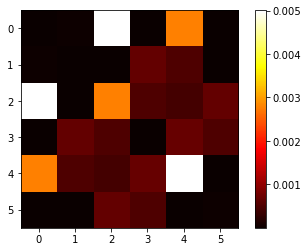

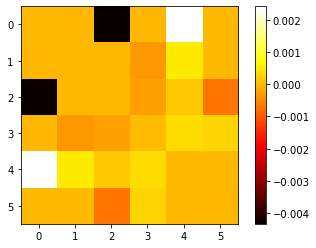

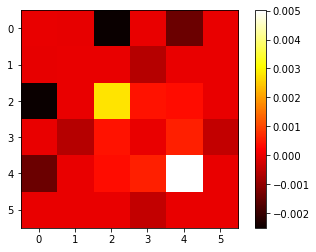

In [123]:
vec = eig[:, 0].reshape((Ls, Ls, n_bands, n_bands))[..., 0, 3].flatten()
import matplotlib.pyplot as plt

maxelem = 1.#vec[np.argmax(np.abs(vec))]
print(maxelem)
plt.imshow(np.abs(vec / maxelem).reshape((Ls, Ls)), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

import matplotlib.pyplot as plt
plt.imshow(np.real(vec / maxelem).reshape((Ls, Ls)), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

import matplotlib.pyplot as plt
plt.imshow(np.imag(vec / maxelem).reshape((Ls, Ls)), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [110]:
eig[:, 0][np.where(np.abs(eig[:, 0].flatten()) > 1e-2)]

array([-0.35340511-8.31756248e-09j,  0.35340511-2.70755478e-09j,
       -0.35340511-9.65183708e-09j,  0.35340511-5.91078951e-09j,
       -0.35340511-1.10251174e-08j,  0.35340511+0.00000000e+00j,
       -0.35340511-1.42283520e-08j,  0.35340511-1.33427439e-09j])